In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import ast
import requests
from scipy import stats
import seaborn as sns
import datetime
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from helpers import *

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/clarawetzel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/clarawetzel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/clarawetzel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/clarawetzel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 0. Loading the data

In [3]:
#load data/moviesummaries/character.metadata.tsv
character_metadata = pd.read_csv('../data/moviesummaries/character.metadata.tsv', sep='\t', header=None)

#load data/moviesummaries/plot_summaries.txt
plot_summaries = pd.read_csv('../data/moviesummaries/plot_summaries.txt', sep='\t', header=None)

#load data/moviesummaries/movie.metadata.tsv
movie_metadata = pd.read_csv('../data/moviesummaries/movie.metadata.tsv', sep='\t', header=None)

#load data/moviesummaries/name.clusters.txt
name_clusters = pd.read_csv('../data/moviesummaries/name.clusters.txt', sep='\t', header=None)


In [4]:
# Rename columns of each dataset to match documentation
character_metadata.columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "Character name", "Actor date of birth", "Actor gender", 
                              "Actor height", "Actor ethnicity", "Actor name", "Actor age", "Freebase character/actor map ID", 
                              "Freebase character ID", "Freebase actor ID"]

plot_summaries.columns = ["Wikipedia movie ID", "Summary"]

movie_metadata.columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", "Movie revenue", "Movie runtime",
                          "Movie languages", "Movie countries", "Movie genres"]

name_clusters.columns = ["Character name", "Freebase character/actor map ID"]

We get 4 different dataframes; we'll merge movie_metadata and plot_summaries together since it makes sense to get the plot information directly linked with the movie metadata, and keep the others as is.

# 1. Preprocessing plot and metadata about movies

We can see from the columns name that we can simply add the plot summaries of the movies to the movie metadata dataframe. Let's first take a look at how many data we have in each dataset :

In [5]:
# Print the size of plot and meta_data dataset
print("Number of data in the metadata dataframe :", movie_metadata.shape[0])
print("Number of data in the plot summaries dataframe :", plot_summaries.shape[0])

Number of data in the metadata dataframe : 81741
Number of data in the plot summaries dataframe : 42303


We can see that approximately half of the movies in the metadata have a plot description. Let's first check if 'Wikipedia movie ID' can be used as a unique key to merge the two dataframes :

In [6]:
# Find out how many duplicates there are in the datasets
print("Numbers of duplicated Wikipedia movie ID in the metadata dataframe : ", movie_metadata["Wikipedia movie ID"].duplicated().sum())
print("Numbers of duplicated Wikipedia movie ID in the plot summaries dataframe : ", plot_summaries["Wikipedia movie ID"].duplicated().sum())

Numbers of duplicated Wikipedia movie ID in the metadata dataframe :  0
Numbers of duplicated Wikipedia movie ID in the plot summaries dataframe :  0


We can see that there are no duplicates in the Wikipedia movie ID column, so we can use it as a unique key to merge the two dataframes. Let's do it; We merge the two dataframes 'left' on the Wikipedia movie ID column, so that we keep all the movies in the metadata dataframe, even those that doesn't have a plot description.

In [7]:
# Merge 'left' the movie_metadata and plot_summaries dataframes on the Wikipedia movie ID column
all_movies = movie_metadata.merge(plot_summaries, on="Wikipedia movie ID", how="left")
all_movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


In [8]:
# Check the number and percentage of null values in each column of all_movies as well as the number of different values in each column.
all_movies_null = pd.DataFrame(all_movies.isnull().sum(), columns=['Number of null values'])
all_movies_null['Percentage of null values'] = all_movies_null['Number of null values'] / len(all_movies)
all_movies_null['Number of unique values'] = all_movies.nunique()

print(all_movies.shape)
all_movies_null


(81741, 10)


,Number of null values,Percentage of null values,Number of unique values
Wikipedia movie ID,0,0.000000,81741
Freebase movie ID,0,0.000000,81741
Movie name,0,0.000000,75478
Movie release date,6902,0.084437,20389
Movie revenue,73340,0.897224,7362
Movie runtime,20450,0.250180,597
Movie languages,0,0.000000,1817
Movie countries,0,0.000000,2124
Movie genres,0,0.000000,23817
Summary,39537,0.483686,42196


As mentioned above, we see that approximately 48% percent of the movie dataset doesn't have a corresponding plot summary!

But what about dupplicated plot summaries? It's very unlikely that 2 movies have the exact same entry, but let's check that :

In [9]:
# Show plot summary duplicates which are not NaNs
duplicate_plot_movies = all_movies[all_movies.duplicated(subset=['Summary'], keep = False) & all_movies['Summary'].notnull()]

# Print number of plot summaries having at least one duplicate
print("Number of plot summaries having at least one duplicate :", duplicate_plot_movies['Summary'].nunique())

duplicate_plot_movies[['Wikipedia movie ID', 'Movie name', 'Summary']].sort_values(by=['Summary'])


Number of plot summaries having at least one duplicate : 5


,Wikipedia movie ID,Movie name,Summary
4551,14055212,The Trial of Madame X,A woman is thrown out of her home by her jealo...
18993,14022275,Madame X,A woman is thrown out of her home by her jealo...
49381,14037732,Madame X,A woman is thrown out of her home by her jealo...
57569,14051944,Madame X,A woman is thrown out of her home by her jealo...
65014,14053389,Madame X,A woman is thrown out of her home by her jealo...
28621,29481480,Drohi,An orphan Raghav turns into a ruthless contrac...
67464,25493367,Antham,An orphan Raghav turns into a ruthless contrac...
15783,14616220,The Warrens of Virginia,"As the American Civil War begins, Ned Burton l..."
57508,28852030,The Warrens of Virginia,"As the American Civil War begins, Ned Burton l..."
22185,19609453,Amar Deep,Raja was adopted by a criminal don at a very ...


We see that there are 5 different plot summaries that have at least one duplicate! In some cases, the duplicate has the same movie name but in other cases, the duplicate has a different movie name. To try to catch the real duplicates, we'll search for rows that share all the same columns except the IDs columns.

In [10]:
# Check for duplicates on all columns except for the ID columns
check_duplicates = all_movies[all_movies.duplicated(subset=["Movie name", "Movie release date", "Movie revenue", "Movie languages", "Movie genres", "Movie countries", "Movie runtime", "Summary"], keep=False)]

check_duplicates.sort_values(by=["Movie name"])

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary
35927,33545359,/m/0hgm4mx,A Sister to Assist 'Er,NaN,NaN,NaN,{},{},"{""/m/05p553"": ""Comedy film""}",NaN
77623,33545325,/m/0hgpm4_,A Sister to Assist 'Er,NaN,NaN,NaN,{},{},"{""/m/05p553"": ""Comedy film""}",NaN
640,32505827,/m/0h1cbks,Dost,NaN,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}",{},NaN
75111,32517667,/m/0h1dthj,Dost,NaN,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}",{},NaN
7009,9386528,/m/0286tgz,Horizontal Axis,NaN,NaN,NaN,{},{},"{""/m/02hmvc"": ""Short Film""}",NaN
79631,9386447,/m/0286tdx,Horizontal Axis,NaN,NaN,NaN,{},{},"{""/m/02hmvc"": ""Short Film""}",NaN
9911,20695929,/m/051zsk3,My Wife's Family,NaN,NaN,NaN,{},"{""/m/07ssc"": ""United Kingdom""}","{""/m/01z4y"": ""Comedy""}",NaN
22389,20696066,/m/051zc20,My Wife's Family,NaN,NaN,NaN,{},"{""/m/07ssc"": ""United Kingdom""}","{""/m/01z4y"": ""Comedy""}",NaN
6010,31255600,/m/0gjb35n,Woman to Woman,NaN,NaN,NaN,{},{},"{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",NaN
53387,31255791,/m/0gjf1sq,Woman to Woman,NaN,NaN,NaN,{},{},"{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",NaN


We notice that those films have a lot of NaN values, but since they share all the same values we don't have a valid reason not to drop them. That's why we chose to drop one of each pair.

In [11]:
# drop one of each pair of duplicates
all_movies.drop_duplicates(subset=["Movie name", "Movie release date", "Movie revenue", "Movie languages", "Movie genres", "Movie countries", "Movie runtime", "Summary"], inplace=True, keep="first")

## Data cleaning

### Movie release date


Let's now take a look at the movies release dates. By looking at the data, we see 4 cases :
 - The release date is a year 
 - The release date is a month and a year 
 - The release date is a day, a month and a year 
 - The release date is not a number

Let's convert every entry to only a year when it's possible :

Defining three functions checking which format is valid for a specific string

In [12]:
character_metadata.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
147811,9177419,/m/027_967,1939,NaN,1885-04-01,M,NaN,NaN,Wallace Beery,NaN,/m/02vb449,NaN,/m/01200d
306169,7843466,/m/026fzc0,2007-02-23,Milly,1979-11-11,F,1.630,/m/0dryh9k,Raima Sen,27.0,/m/02tb3s7,/m/0h5l_x5,/m/08tcyn
143145,10620698,/m/02qkfwk,1979-03-24,Master Chou Cheng,1940-03-11,M,NaN,NaN,Shen Chan,39.0,/m/0lb95cl,/m/0lb95cp,/m/047phjy
373361,373905,/m/020stv,1998-02-25,Mormon Thug #2,NaN,M,NaN,NaN,Don Creech,NaN,/m/0gcg8rn,/m/0n3vnf4,/m/0271vrx
16403,16280949,/m/03wfxw8,1987-10-09,NaN,1945-03-30,M,1.820,NaN,Eric Clapton,42.0,/m/04dg4tc,NaN,/m/02qwg
71882,2617126,/m/07s114,2005-11-09,Marcus,1975-07-06,M,1.829,/m/0x67,50 Cent,30.0,/m/0jyqmv,/m/0h5srk4,/m/01vvyc_
436210,32181922,/m/0gx_0v3,2012,NaN,1972-10-26,M,NaN,NaN,Riaz,39.0,/m/0gy4pzd,NaN,/m/0gh6zgt
11676,23292818,/m/065_37_,1982,Bobby Russo's Daughter,1959-01-17,F,1.570,/m/041rx,Susanna Hoffs,22.0,/m/0n1ydrb,/m/0n20yxf,/m/04c661
271641,6491526,/m/0g7d7b,1995,NaN,1969-07-31,M,1.803,NaN,Loren Dean,25.0,/m/0ghrmkv,NaN,/m/033tmw
430485,5401902,/m/0dk6ry,1991,NaN,1961-11-27,M,NaN,NaN,Steve Oedekerk,29.0,/m/03lmcnq,NaN,/m/04l3_z


Converting the movie release date to keep only the year for the all_movie table :

In [13]:
all_movies = keep_the_year(all_movies, key='Movie release date')

### Dictionnary structures

In [14]:
# Print examples of the 'Movie countries', 'Movie genres' and 'Movie languages' columns as well as their types
print(all_movies['Movie countries'].iloc[0])
print(type(all_movies['Movie countries'].iloc[0]))
print(all_movies['Movie genres'].iloc[0])
print(type(all_movies['Movie genres'].iloc[0]))
print(all_movies['Movie languages'].iloc[0])
print(type(all_movies['Movie languages'].iloc[0]))

{"/m/09c7w0": "United States of America"}
<class 'str'>
{"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}
<class 'str'>
{"/m/02h40lc": "English Language"}
<class 'str'>


We see that some columns are written as a dictionnary but saved as a string. 

Three columns are concerned by this problem:
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)

Since we will not use the Freebase IDs, let's only keep the values of these dicts as lists.

In [15]:
all_movies['Movie genres'] = [list(eval(genre).values()) for genre in all_movies['Movie genres']]
all_movies['Movie languages'] = [list(eval(genre).values()) for genre in all_movies['Movie languages']]
all_movies['Movie countries'] = [list(eval(genre).values()) for genre in all_movies['Movie countries']]
print(all_movies['Movie countries'].iloc[0])
print(type(all_movies['Movie countries'].iloc[0]))
print(all_movies['Movie genres'].iloc[0])
print(type(all_movies['Movie genres'].iloc[0]))
print(all_movies['Movie languages'].iloc[0])
print(type(all_movies['Movie languages'].iloc[0]))

['United States of America']
<class 'list'>
['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western']
<class 'list'>
['English Language']
<class 'list'>


Now, we have a proper dataframe containing metadata and plot summaries about movies: all_movies

# 2. Preprocessing characters metadata

In [16]:
character_metadata.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
425053,22224886,/m/05q4pcp,1983-10,The Expert,1953-08-18,M,NaN,/m/0222qb,Sergio Castellitto,NaN,/m/0n1qdgs,/m/0n1qgq0,/m/02643n_
226606,16683731,/m/03ymn75,1999-05-17,NaN,1966-05-16,M,1.72,NaN,Scott Reeves,33.0,/m/0hlk92z,NaN,/m/0300qs
132264,28070112,/m/0cm9jw2,2010-10-08,Merv,1964,M,1.82,NaN,Richard Dillane,46.0,/m/0h7rcnj,/m/0hcd5s8,/m/02w349t
356239,19353900,/m/04myzdy,2007,NaN,NaN,NaN,NaN,NaN,Rupinda Nagra,NaN,/m/04mw9rl,NaN,/m/04mw9rp
33564,7766450,/m/0kvgt0,2003-01-01,NaN,NaN,M,NaN,NaN,Tracy Goode,NaN,/m/0gc7bdt,NaN,/m/05s_8lw
263492,5823255,/m/0f7c39,1979-11-17,NaN,1908-12-28,M,1.75,NaN,Lew Ayres,70.0,/m/0cfzzxn,NaN,/m/01386m
73370,2196940,/m/06v5th,2000-05-16,NaN,NaN,M,NaN,NaN,Luiz Carlos Vasconcelos,NaN,/m/0cw0plg,NaN,/m/0jv6dw
68193,210227,/m/01dvq4,1964-11-09,NaN,1893-02-19,M,NaN,NaN,Cedric Hardwicke,NaN,/m/0cw0kvx,NaN,/m/017d3v
420192,835620,/m/03fpvm,1960-07-10,NaN,1903-11-12,M,1.80,NaN,Jack Oakie,56.0,/m/0k67wd,NaN,/m/04x946
26851,8967683,/m/027rlj9,1985,NaN,1959-06-06,F,1.70,NaN,Amanda Pays,25.0,/m/02vbrgh,NaN,/m/018ftv


Taking a quick look, we see that we encounter the same problem with the "Movie release date" and " Actor date of birth" as seen before. Let's convert every entry to only a year when it's possible :

In [17]:
character_metadata = keep_the_year(character_metadata, key='Movie release date')
character_metadata = keep_the_year(character_metadata, key='Actor date of birth')

# 3. Learning more about the data

### Chronological evolution of movie production

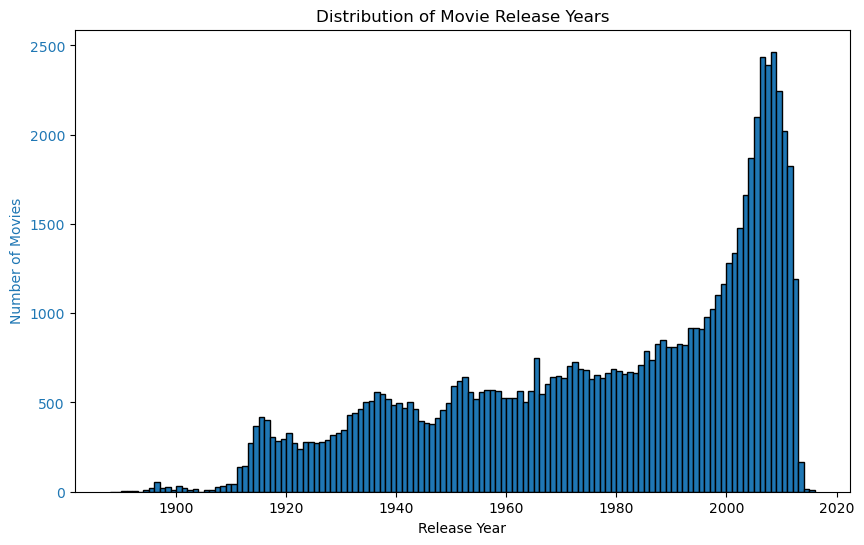

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Creating an histogram plotting the values of 'year'
ax1.hist(all_movies['Movie release date'].dropna(), bins=range(int(all_movies['Movie release date'].min()), int(all_movies['Movie release date'].max()) + 1), edgecolor='black', label='Movie Releases')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Number of Movies', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Distribution of Movie Release Years')
plt.show()

Looking at the plot we can see that we have more data for recent films.

### Movie countries and genres

We compute the top 10 countries and genres. For co-produced movies, we count an additional movie per co-producing country. For example, a movie co-produced by the USA and India will add +1 movie produced for both of these countries. The same logic applies for the movie genres.

In [19]:
# Print number of unique movie countries, genres and languages

unique_countries_list = all_movies['Movie countries'].explode().unique()
unique_genres_list = all_movies['Movie genres'].explode().unique()
unique_languages_list = all_movies['Movie languages'].explode().unique()

print('Number of unique movie countries:', len(unique_countries_list))
print('Number of unique movie genres:', len(unique_genres_list))
print('Number of unique movie languages:', len(unique_languages_list))

Number of unique movie countries: 148
Number of unique movie genres: 364
Number of unique movie languages: 208


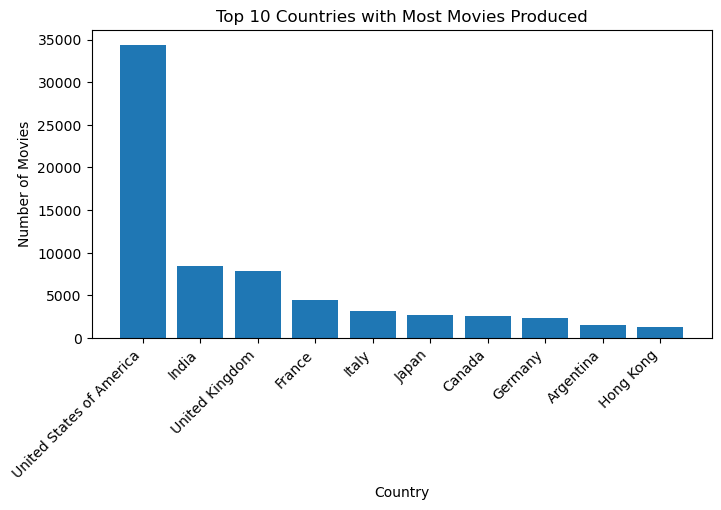

The top production country is United States of America and concerns 39.81% of all movies produced.


In [20]:
# Compute a box plot of top 10 countries with most movies produced or coproduced
country_counts = {}

for countries in all_movies['Movie countries']:
    for country in countries:
        if country in country_counts:
            country_counts[country] += 1
        else:
            country_counts[country] = 1

# Get the top 10 countries
top_countries = sorted(country_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a new DataFrame with the top countries
top_countries_df = pd.DataFrame(top_countries, columns=['Country', 'Count'])

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(top_countries_df['Country'], top_countries_df['Count'])
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.title('Top 10 Countries with Most Movies Produced')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print the top 1 country and its percentage
top_1_country = top_countries_df['Country'].iloc[0]
percentage = country_counts[top_1_country] / sum(country_counts.values()) * 100
print(f'The top production country is {top_1_country} and concerns {percentage:.2f}% of all movies produced.')

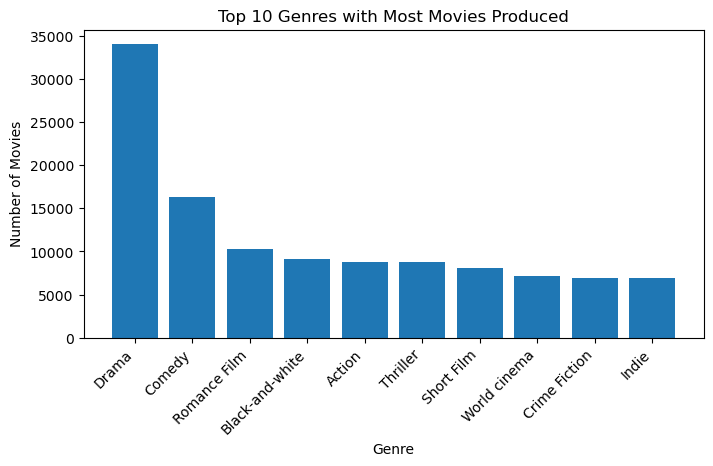

The top genre is Drama and represents 13.98% of all movies produced.


In [21]:
# Compute a box plot of top 10 genres with most movies produced
genre_counts = {}

for genres in all_movies['Movie genres']:
    for genre in genres:
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1

# Get the top 10 genres
top_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a new DataFrame with the top genres
top_genres_df = pd.DataFrame(top_genres, columns=['Genre', 'Count'])

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(top_genres_df['Genre'], top_genres_df['Count'])
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Top 10 Genres with Most Movies Produced')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print the top 1 genre and its percentage
top_1_genre = top_genres_df['Genre'].iloc[0]
percentage = genre_counts[top_1_genre] / sum(genre_counts.values()) * 100
print(f'The top genre is {top_1_genre} and represents {percentage:.2f}% of all movies produced.')

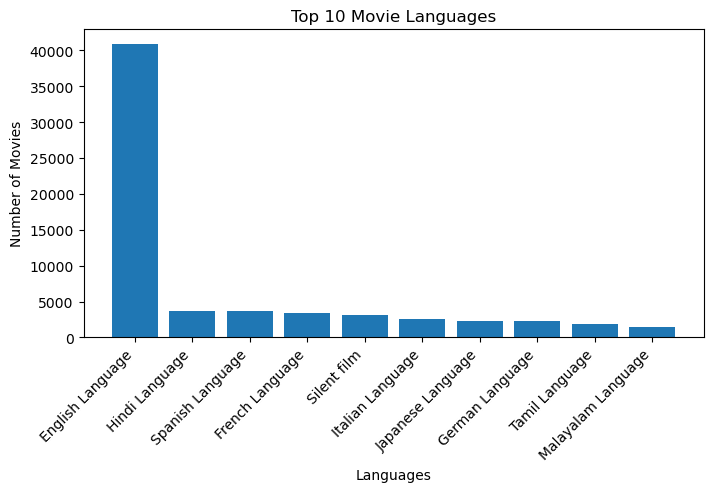

The top language is "English Language" and represents 50.29% of all movies produced.


In [22]:
# Compute a box plot of top 10 genres with most movies produced
language_counts = {}

for languages in all_movies['Movie languages']:
    for language in languages:
        if language in language_counts:
            language_counts[language] += 1
        else:
            language_counts[language] = 1

# Get the top 10 genres
top_languages = sorted(language_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a new DataFrame with the top genres
top_languages_df = pd.DataFrame(top_languages, columns=['Language', 'Count'])

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(top_languages_df['Language'], top_languages_df['Count'])
plt.xlabel('Languages')
plt.ylabel('Number of Movies')
plt.title('Top 10 Movie Languages')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print the top 1 genre and its percentage
top_1_language = top_languages_df['Language'].iloc[0]
percentage = language_counts[top_1_language] / sum(language_counts.values()) * 100
print(f'The top language is "{top_1_language}" and represents {percentage:.2f}% of all movies produced.')


These results show us that an analysis of the whole dataset will actually be more representative of movies produced or co-produced in the USA, movies belonging to the genre Drama and movies in english. The reason why the percentage of english movies is so high is not only because the USA is the largest producing country but also because a lot of movies might be translated in english.

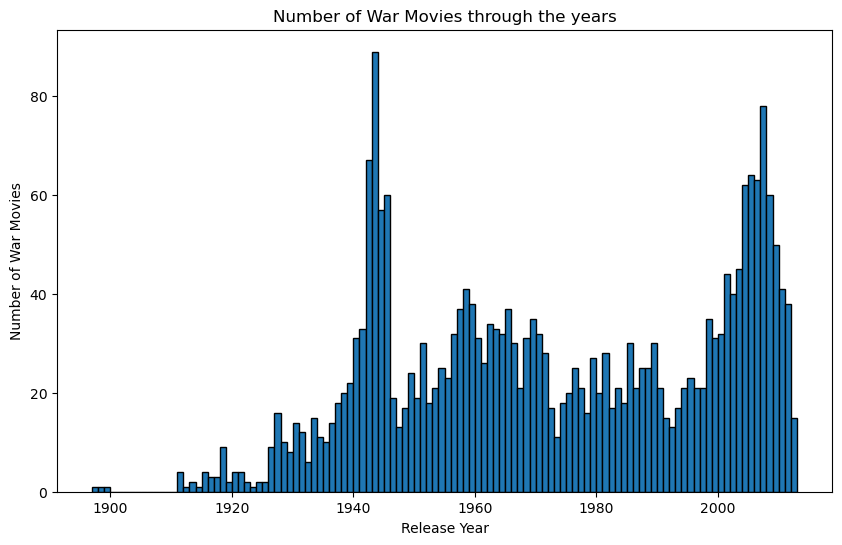

In [23]:
# Selecting columns 'Movie genres' and 'Movie release date'
genre_date = all_movies[['Movie genres', 'Movie release date']]

# Drop rows with missing values in 'Movie genres' column
genre_date = genre_date.dropna(subset=['Movie genres'])

# Explode the 'Movie genres' column
genre_date = genre_date.explode('Movie genres')

# Drop rows with missing values in the exploded 'Movie genres' column
genre_date = genre_date.dropna(subset=['Movie genres'])

# Selecting rows where the movie genre is 'War film'
war_movies = genre_date[genre_date['Movie genres'].str.contains('War film')]

# Reset the index and drop nan values
war_movies = war_movies.reset_index(drop=True).dropna()

#plot the distribution of the number of movies per year for the 'War film' genre
plt.figure(figsize=(10, 6))
plt.hist(war_movies['Movie release date'], bins=range(int(war_movies['Movie release date'].min()), int(war_movies['Movie release date'].max()) + 1), edgecolor='black')
plt.xlabel('Release Year')
plt.ylabel('Number of War Movies')
plt.title('Number of War Movies through the years')
plt.show()

This graph shows the evolution of the number of film about war depending on the years. We can see that there is a first peak around 1945 and a second one around 2010. The first peak could be explained by the Second World War, and the second peak could have several causes, such as the augmentation of the number of terrorist attack in USA and Europe or the augmentation of tension between Russia and USA.

## Missing values

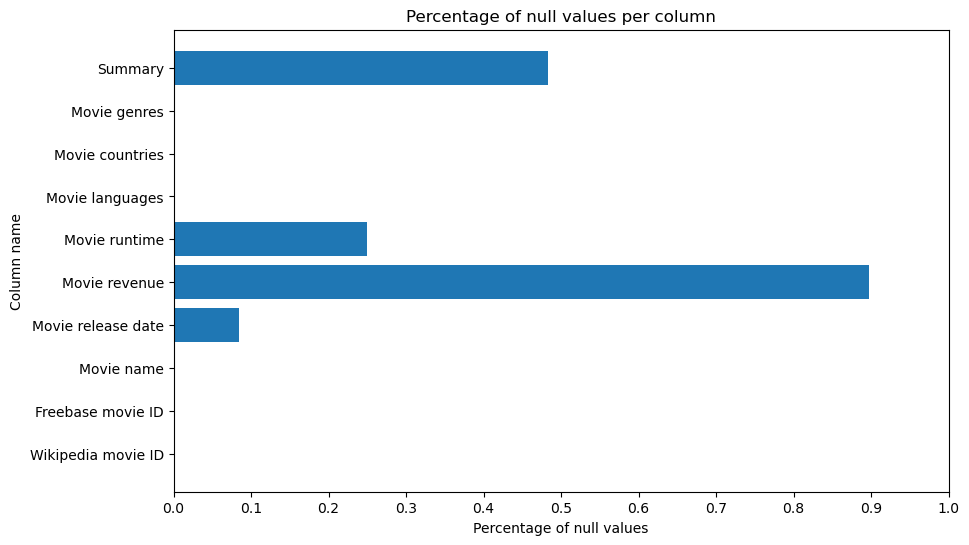

Percentage of missing values in movie revenue: 89.72%


In [24]:
# plot the percentage of missing values for all columns in the all_movies dataframe
plt.figure(figsize=(10, 6))
plt.barh(all_movies_null.index, all_movies_null['Percentage of null values'])
plt.xlabel('Percentage of null values')
plt.ylabel('Column name')
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.title('Percentage of null values per column')
plt.show()

print(f"Percentage of missing values in movie revenue: {100*all_movies_null['Percentage of null values']['Movie revenue']:.2f}%")

We see that there are a lot of missing values of the movie revenues (around 90%), we need to find another metric for judging films popularity. IMDb ratings seem to be a good alternative. This dataset contains the average IMDb rating of movies and the number of votes.

# 4. Add IMDb ratings

### Load the data

In [25]:
movie_ratings = pd.read_csv('../data/title.ratings.tsv', sep='\t', header=0)

In [26]:
movie_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2006
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2689


### Use Wikidata query to create a table that links IMDb identifier tconst with Freebase ID

Since multiple movies have the same name and appear the same year, we have to link the two dataset using freebase ID of the movies in the original dataset and the unique identifier tconst of the IMDb ratings dataset. We use Wikidata query to create a link table

In [27]:
# Create the table
link_id = link_tconst_freebaseID()

# Drop duplicates
link_id = link_id.drop_duplicates(subset=['tconst'])
link_id = link_id.drop_duplicates(subset=['Freebase movie ID'])

link_id.head()

,tconst,Freebase movie ID
0,nm0010930,/m/0282x
1,nm0124133,/m/09b6zr
2,nm0684496,/m/014d3
3,nm0061667,/m/01rgr
4,tt1675434,/m/0hgqwpj


### Merge the two datasets

In [28]:
# Add freebase ID to movie_ratings
movie_ratings = pd.merge(movie_ratings, link_id, on='tconst', how='left')
movie_ratings.head()

,tconst,averageRating,numVotes,Freebase movie ID
0,tt0000001,5.7,2006,/m/0kvdsy
1,tt0000002,5.8,269,/m/02pz844
2,tt0000003,6.5,1909,/m/0g53g2
3,tt0000004,5.5,178,/m/02pzdsc
4,tt0000005,6.2,2689,/m/0jq3g


In [29]:
# Merge all_movies and movie_ratings
all_movies = pd.merge(all_movies, movie_ratings, on='Freebase movie ID', how='left')
# Drop tconst column
all_movies.drop(columns=['tconst'], inplace=True)

all_movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",4.9,56908.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN,6.0,69.0
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN,5.6,40.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,6.1,2895.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...",5.9,623.0


In [30]:
# Percentage of missing values in the columns averageRatings and num votes
print('Percentage of missing values in averageRatings: {:.2f}%'.format(100 * all_movies['averageRating'].isnull().sum() / len(all_movies)))
print('Percentage of missing values in numVotes: {:.2f}%'.format(100 * all_movies['numVotes'].isnull().sum() / len(all_movies)))

Percentage of missing values in averageRatings: 16.99%
Percentage of missing values in numVotes: 16.99%


We have far fewer missing values in ratings than in revenues.

### Correlation between movie revenue and average rating

Percentage of movies for which we have both informations: 10.18% 
 

Person correlation between movie revenue and average rating:  PearsonRResult(statistic=0.16823475825985873, pvalue=6.763377264292565e-54) 
 



/Users/clarawetzel/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


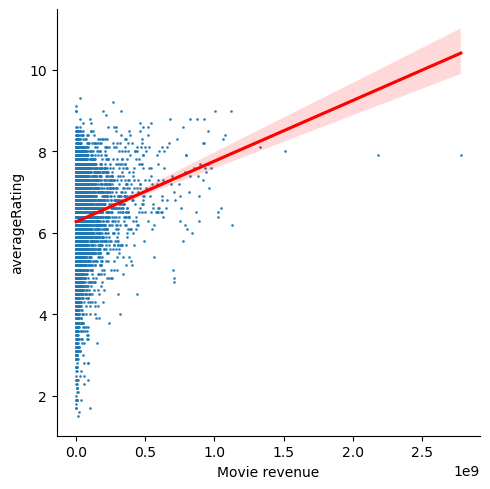

In [31]:
# Keep movies for which we have both informations
df1 = all_movies.dropna(subset=['Movie revenue', 'averageRating'])

# What percentage of the whole dataset does it represent
print("Percentage of movies for which we have both informations: {:.2f}%".format(100 * len(df1) / len(all_movies)), '\n', '\n')

# Pearson correlation between the movie revenue and the average rating
df1_pearson = stats.pearsonr(df1['Movie revenue'], df1['averageRating'])
print("Person correlation between movie revenue and average rating: ", df1_pearson, '\n', '\n')

# Plot the correlation between the movie revenue and the average rating
sns.lmplot(x='Movie revenue', y='averageRating', data=df1, scatter_kws={"s": 1}, line_kws={'color': 'red'})

There is a significant positive correlation between a movie revenue and its average rating.

### Correlation between movie revenue and number of votes for rating

Percentage of movies for which we have both informations: 10.18% 
 

Person correlation between movie revenue and numVotes:  PearsonRResult(statistic=0.6550136090668378, pvalue=0.0) 
 



/Users/clarawetzel/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


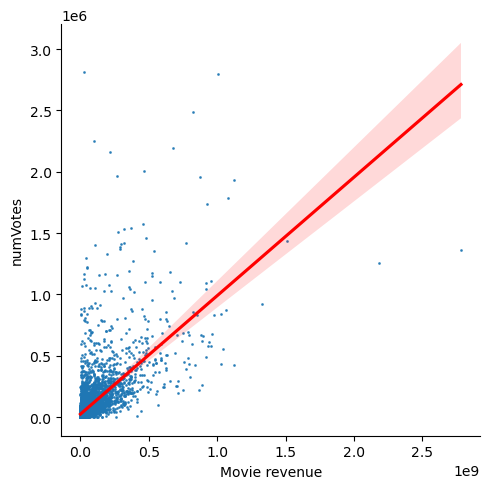

In [32]:
# Keep movies for which we have both informations
df2 = all_movies.dropna(subset=['Movie revenue', 'numVotes'])

# What percentage of the whole dataset does it represent
print("Percentage of movies for which we have both informations: {:.2f}%".format(100 * len(df2) / len(all_movies)), '\n', '\n')

# Pearson correlation between the movie revenue and the average rating
df2_pearson = stats.pearsonr(df2['Movie revenue'], df2['numVotes'])
print("Person correlation between movie revenue and numVotes: ",df2_pearson, '\n', '\n')


# Plot the correlation between the movie revenue and the average rating
sns.lmplot(x='Movie revenue', y='numVotes', data=df2, scatter_kws={"s": 1}, line_kws={'color': 'red'})

There is a significant positive correlation between a movie revenue and its number of votes.

Looking at the previous graphs, the positive correlation between the data confirms that using the movie reviews and number of votes in a similar extent as the movie revenue is reasonable.

# Correlation

### Movie release year - Movie average rating

/var/folders/60/n3wml7t139732y5n5jgc1bqc0000gn/T/ipykernel_87839/148172858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Movie release date'] = df3['Movie release date'].astype(int)
/Users/clarawetzel/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)



 
 Percentage of movies for which we have both informations: 77.54% 
 

Person correlation between movie revenue and numVotes:  PearsonRResult(statistic=-0.055250214816706965, pvalue=4.794269059472481e-44) 
 



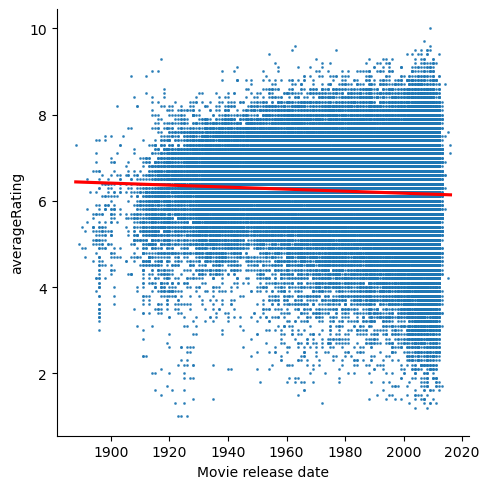

In [33]:
# Keep movies for which we have both informations
df3 = all_movies.dropna(subset=['Movie release date', 'averageRating'])
df3['Movie release date'] = df3['Movie release date'].astype(int)

# What percentage of the whole dataset does it represent
print('\n', '\n', "Percentage of movies for which we have both informations: {:.2f}%".format(100 * len(df3) / len(all_movies)), '\n', '\n')

# Pearson correlation between the movie revenue and the average rating
df3_pearson = stats.pearsonr(df3['Movie release date'], df3['averageRating'])
print("Person correlation between movie revenue and numVotes: ", df3_pearson, '\n', '\n')

# Plot the correlation between the movie revenue and the average rating
sns.lmplot(x='Movie release date', y='averageRating', data=df3, scatter_kws={"s": 1}, line_kws={'color': 'red'})

There is a significative but very weak negative correlation between the two variables.

# NLP

## Data cleaning

To perform NLP with a better performance, a few transformation and modification are needed on the summaries. \
We did the following transformations:\
- Tokenization on white space
- Removal of punctuation
- Stopword removal (based on the "english" stopword library from nltk as well as very common words in summaries (film, films, movie and movies))
- Lemmatization

In [34]:
path = '../data/'
all_movies_cleaned, character_metadata_cleaned, name_clusters_cleaned = get_cleaned_data(path)

# CLEANED movie summaries
all_movies_cleaned = all_movies_cleaned.dropna(subset=['Summary']) # ADD DROPNA IN GET_SUMMARIES ?
all_movies_cleaned.head()


Loading the data...
Loading and cleaning the summaries...
processed_summaries.tsv not found, processing the summaries...
Tokenizing...
Removing punctuation...
Removing stop words / movie_film...
POS tagging...
Lemmatizing...
Saving the processed summaries...
Cleaning the data...
Adding IMDb ratings...


,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",second half century depicts planet terraformed...,4.9,56908.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",series murder rich young woman throughout bear...,6.1,2895.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],upper class housewife becomes frustrated leaf ...,5.9,623.0
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",Every hundred year evil return claim wizard in...,NaN,NaN
12,6631279,/m/0gffwj,Little city,1997,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",artist work cab driver side hard time committi...,5.8,1129.0


In [35]:
# NOT CLEANED movie summaries (for comparison sake)
# First we copy all_movies and filter to only keep movies with a plot summary
all_movies_not_cleaned = all_movies.copy()
all_movies_not_cleaned = all_movies_not_cleaned.dropna(subset=['Summary'])
all_movies_not_cleaned.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",4.9,56908.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,6.1,2895.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...",5.9,623.0
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns...",NaN,NaN
12,6631279,/m/0gffwj,Little city,1997,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a...",5.8,1129.0


## NLP basics

We first try to generate topics from the plot summaries using LDA.

In [36]:
# CLEANED movie summaries (for comparison sake)
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(all_movies_cleaned['Summary'])

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=15, random_state=0)
lda.fit(count_data)
print_lda_infos(lda, count_vectorizer, count_data, all_movies_cleaned)

Number of topics:15

Topics found via LDA:
Topic 0:
life young woman man vampire one town people begin becomes
Topic 1:
find back take king boy help one return however castle
Topic 2:
story character scene people also life one cite first group
Topic 3:
tell go house get see find home back mother day
Topic 4:
find train one escape back two get go car boat
Topic 5:
get back song band cat show see end run one
Topic 6:
father family brother son village love get daughter take gang
Topic 7:
soldier war men order officer attack one killed army mission
Topic 8:
find body kill house back town dead one killed head
Topic 9:
get school team game money win make new job one
Topic 10:
alien human creature ship scientist monster planet space one back
Topic 11:
love life family father friend mother child time marriage meet
Topic 12:
police kill murder find man one killed prison case death
Topic 13:
power fight find one world battle year death life evil
Topic 14:
woman life man friend young get one wife

In [37]:
# NOT CLEANED movie summaries (for comparison sake)
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(all_movies_not_cleaned['Summary'])

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=15, random_state=0)
lda.fit(count_data)
print_lda_infos(lda, count_vectorizer, count_data, all_movies_not_cleaned)

Number of topics:15

Topics found via LDA:
Topic 0:
george money man life father alice tells band old family
Topic 1:
tom house school tells jerry goes home gets night room
Topic 2:
film harry world new crew earth movie time ship story
Topic 3:
johnny jake vampire daniel kim road mary dracula joey su
Topic 4:
police man killed car gang kill murder killer dead escape
Topic 5:
new jim joe money eddie family father home time tells
Topic 6:
war army men david soldiers killed german fight japanese battle
Topic 7:
bugs sam daffy tells away ship tries king wolf just
Topic 8:
mother love life father family young wife woman home new
Topic 9:
love father family life son story daughter gets mother comes
Topic 10:
film ben jimmy john president life kate new story town
Topic 11:
peter anna tells family time christmas scott luke home father
Topic 12:
jack danny max larry tells car ray money later man
Topic 13:
charlie dr fred earth city world monster bond time powers
Topic 14:
prince queen king prin

We see that cleaning the data gives us much more informative topics. From now on, we use only the all_movies_cleaned data.

Giving a quick look at the topics and the genres of the movies associated with them (printed at the end of the lines), we can see that LDA is able to generate topics that are coherent with the genres of the movies. We can attribute the topics the following labels:
- Topic 0: Drama
- Topic 1: Family
- Topic 2: SF
- Topic 3: Horror
- Topic 4: Thriller
- Topic 5: Drama (again)
- Topic 6: Chinese
- Topic 7: Animation
- Topic 8: Drama (again)
- Topic 9: Bollywood
- Topic 10: Politics
- Topic 11: Family/animation
- Topic 12: This one feels unclear
- Topic 13: Superhero
- Topic 14: Japanese/fantasy

There are clearly improvements that can be made. First of all we could consider names as stopwords since we see that a ot of words used to describe the topics are names. Usually this is unwanted. We could also try to use a different number of topics, even though we have already tried different values. Finally we can try to filter out some genres before proceeding to LDA. We show an example next.

In [38]:
keep = ['Alien Film', 'Alien invasion','Anti-war', 'Anti-war film','Apocalyptic and post-apocalyptic fiction','Cold War', 'Combat Films',
        'Computers', 'Conspiracy fiction', 'Costume Horror', 'Dystopia', 'Environmental Science', 'Future noir', 'Gulf War', 'Natural disaster', 
        'Natural horror films', 'Nuclear warfare', 'Plague', 'Sci-Fi Horror', 'War film', ]

# filter out rows that do not contain any of the genres in the keep list
all_movies_filtered = all_movies_cleaned[all_movies_cleaned['Movie genres'].apply(lambda x: any(item for item in x if item in keep))]

In [39]:
# Perform LDA on the summaries

# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(all_movies_filtered['Summary'])

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(count_data)
print_lda_infos(lda, count_vectorizer, count_data, all_movies_filtered)

Number of topics:10

Topics found via LDA:
Topic 0:
return vampire tell attack life castle force kill brother home
Topic 1:
make escape help life begin people time police end try
Topic 2:
war time life love family friend home son year later
Topic 3:
war tank force year army end woman horse british guerrilla
Topic 4:
ship alien crew creature kill escape attack team human boat
Topic 5:
camp prisoner escape soldier men british french war killed woman
Topic 6:
family mother father life child tell return attack son boy
Topic 7:
mission german pilot aircraft japanese attack crew officer british fighter
Topic 8:
crocodile sheep group life love story father return fall young
Topic 9:
soldier men officer order war kill killed tell japanese village
Top documents for each topic:
Topic 0:
[('begin monologue vampire telling story lycans vampire year since war begun set several year built army vampire fight threat begun process exterminating lycans appears someone infected lycan transform werewolf c

In [49]:
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.utils import simple_preprocess

# Tokenize the text in the 'Summary' column
all_movies_cleaned['Summary_tokens'] = all_movies_cleaned['Summary'].apply(simple_preprocess)

# Create a dictionary from the movie summaries
dictionary = Dictionary(all_movies_cleaned['Summary_tokens'])

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in all_movies_cleaned['Summary_tokens']]

# Set up the parameters
seed = 42
params = {'passes': 10, 'random_state': seed}

# Create the LDA model
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                     passes=params['passes'], random_state=params['random_state'])

### Graph for all the movies and 4 topics

In [50]:
model.show_topics(num_words=5)


[(0,
  '0.008*"police" + 0.006*"one" + 0.006*"man" + 0.005*"kill" + 0.005*"life"'),
 (1, '0.007*"find" + 0.006*"back" + 0.006*"one" + 0.005*"go" + 0.005*"take"'),
 (2,
  '0.010*"love" + 0.009*"get" + 0.007*"father" + 0.007*"take" + 0.007*"money"'),
 (3, '0.006*"life" + 0.006*"friend" + 0.006*"one" + 0.006*"go" + 0.006*"get"')]

In [51]:
model.show_topic(1,20)

[('find', 0.0072921156),
 ('back', 0.0060671484),
 ('one', 0.005587512),
 ('go', 0.0050004646),
 ('take', 0.0046174233),
 ('get', 0.0041002347),
 ('escape', 0.003999784),
 ('two', 0.0039212415),
 ('tell', 0.003864138),
 ('kill', 0.0036866881),
 ('see', 0.0036847503),
 ('try', 0.0036014863),
 ('begin', 0.003150955),
 ('house', 0.0031216927),
 ('head', 0.0030920978),
 ('away', 0.0030612238),
 ('attack', 0.003013066),
 ('time', 0.0029822255),
 ('run', 0.0029339541),
 ('attempt', 0.0028568103)]

In [52]:
import pyLDAvis.gensim_models

# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

### Graph for all the movies and 8 topics

In [53]:
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.utils import simple_preprocess

# Tokenize the text in the 'Summary' column
all_movies_cleaned['Summary_tokens'] = all_movies_cleaned['Summary'].apply(simple_preprocess)

# Create a dictionary from the movie summaries
dictionary = Dictionary(all_movies_cleaned['Summary_tokens'])

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in all_movies_cleaned['Summary_tokens']]

# Set up the parameters
seed = 42
params = {'passes': 10, 'random_state': seed}

# Create the LDA model
model = LdaMulticore(corpus=corpus, num_topics=8, id2word=dictionary, workers=6,
                     passes=params['passes'], random_state=params['random_state'])

In [54]:
# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

### 4 topics for war movies


In [55]:
# Tokenize the text in the 'Summary' column
all_movies_filtered['Summary_tokens'] = all_movies_filtered['Summary'].apply(simple_preprocess)

# Create a dictionary from the movie summaries
dictionary = Dictionary(all_movies_filtered['Summary_tokens'])

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in all_movies_filtered['Summary_tokens']]

# Set up the parameters
seed = 42
params = {'passes': 10, 'random_state': seed}

# Create the LDA model
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                     passes=params['passes'], random_state=params['random_state'])

/var/folders/60/n3wml7t139732y5n5jgc1bqc0000gn/T/ipykernel_87839/2576102568.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_movies_filtered['Summary_tokens'] = all_movies_filtered['Summary'].apply(simple_preprocess)


In [56]:
# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)